In [2]:
import numpy
import matplotlib.pyplot as plt
from PIL import Image
import sklearn

In [2]:
def _get_image_as_array(path: str):
    im = Image.open(path)
    im = im.convert(mode="L")
    
    arr = numpy.asarray(im)

    return arr


In [3]:
def _transform_complexArray_to_real(i_arr: numpy.ndarray):
    ret = numpy.absolute(i_arr)
    return ret

In [21]:
def _high_pass_filter(arr: numpy.ndarray, radius: float):
    ret = numpy.zeros((arr.shape[0],arr.shape[1]),dtype=complex)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if i/radius + j/radius - 1 < 0:
            #if i > arr.shape[0]*radius and j > arr.shape[1]*radius:
            #if (i - arr.shape[0]/2)**2 + (j - arr.shape[1]/2)**2 - radius**2 > 0:
                ret[i][j] = arr[i][j]
            else:
                ret[i][j] = 0
    return ret

def _transform_circular(arr: numpy.ndarray):
    ret = numpy.zeros((arr.shape[0], arr.shape[1]))
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if (i - arr.shape[0]/2)**2 + (j - arr.shape[1]/2)**2 -(arr.shape[0]/2)**2 <= 0:
                ret[i][j] = arr[i][j]
            else:
                ret[i][j] = 0
    return ret



In [19]:
def _fft_edge_detector(path: str, radius: float, show: bool):
    image_arr = _get_image_as_array(path)
    #plt.figure("original")
    #plt.imshow(image_arr, interpolation='none')
    #plt.title("Original image")

    image_fft = numpy.fft.fft2(image_arr)
    #plt.figure("dft of image")
    #plt.imshow(_transform_complexArray_to_real(image_fft), interpolation='none')
    #plt.title("dft of image")
    if show:
        im = Image.fromarray(_transform_complexArray_to_real(image_fft))
        im.show()

    fft_filtered = _high_pass_filter(image_fft, radius)
    #plt.figure("filtered dft")
    #plt.imshow(_transform_complexArray_to_real(fft_filtered), interpolation='none')
    #plt.title("filtered dft")
    if show:
        im = Image.fromarray(_transform_complexArray_to_real(fft_filtered))
        im.show()

    filtered_Image = numpy.fft.ifft2(fft_filtered)
    #plt.figure(radius)
    #plt.imshow(_transform_complexArray_to_real(filtered_Image), interpolation='none')
    #plt.title(f"Edge detected {radius}")
    if show:
        im = Image.fromarray(_transform_complexArray_to_real(filtered_Image))
        im.show()
    return _transform_complexArray_to_real(filtered_Image)



In [4]:
from scipy.signal import convolve2d
from PIL.ImageFilter import GaussianBlur
from PIL import Image
import numpy
def _robert_edge_detector(path: str, blur: float, passfilter: int):
    #gx = numpy.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    #gy = numpy.array([[1,2,1],[0,0,0], [-1,-2,-1]])

    gx = numpy.array([[1,0],[0,-1]])
    gy = numpy.array([[0,1], [-1,0]])

    im = Image.open(path).convert("L")
    im = numpy.asarray(im)

    GX = convolve2d(im, gx, mode='same') 
    GY = convolve2d(im, gy, mode='same')

    if blur > 0:
        G = numpy.array([[0.1,0.1],[0.1,0.1]])
        im = convolve2d(im, blur*G, mode='same')

        GX = convolve2d(im, gx, mode='same') * 1/numpy.sum(G)
        GY = convolve2d(im, gy, mode='same') * 1/numpy.sum(G)

    
    ret = numpy.absolute(GX) + numpy.absolute(GY)

    if passfilter > 0:
        th = passfilter
        th = numpy.average(ret)
        indxL = numpy.where(ret < th)
        indxH = numpy.where(ret >= th)

        ret[indxL] = 0
        ret[indxH] += 50 

    return ret

im = _robert_edge_detector("sample/profile.jpg", -1, -1)
print(numpy.average(im))
passfilter = True

im = Image.fromarray(im.astype(numpy.uint8))
im.show()
im.save("sample/edge.jpg")

5.3826467255015435


In [32]:
from PIL import Image
import numpy
def _split_mat(arr: numpy.ndarray, blk_size: int = 16):
    l = numpy.split(arr, list(range(blk_size,arr.shape[0],blk_size)))
    split = []
    for x in l:
        tmp = numpy.split(x, list(range(blk_size,arr.shape[0],blk_size)), axis=1)
        for y in tmp:
            split.append(y)
    return split
# bin(4)
def get_ubins():
    bins = []
    for i in range(256):
        bin_form = bin(i)
        bin_form = bin_form[2:]
        trns = 0
        #while len(bin_form) <= 8:
         #  bin_form = '0' + bin_form
        curr = bin_form[0]
        prev = bin_form[0]
        for x in bin_form:
            prev = curr
            curr = x
            if curr != prev:
                trns +=1
        if trns <= 2:
            bins.append(i)
    return bins

bins = get_ubins()

def _lbph_algorithm(path: str, ubins: list):
    im = Image.open(path).convert("L")
    im = numpy.array(im)
    min_indx = 0
    max_indx = im.shape[0]
    im.setflags(write=True)

    for i in range(max_indx):
        for j in range(max_indx):

            lbp = ''

            if (i-1) > min_indx and (j-1) > min_indx:
                if im[i][j] >= im[i-1][j-1]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i-1) > min_indx and (j) < max_indx:
                if im[i][j] >= im[i-1][j]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i-1) > min_indx and (j+1) < max_indx:
                if im[i][j] >= im[i-1][j+1]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i) < max_indx and (j+1) < max_indx:
                if im[i][j] >= im[i][j+1]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i+1) < max_indx and (j+1) < max_indx:
                if im[i][j] >= im[i+1][j+1]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i+1) < max_indx and (j) < max_indx:
                if im[i][j] >= im[i+1][j]:
                    lbp += '0'
                else:
                    lbp += '1'
            
            if (i+1) < max_indx and (j-1) > min_indx:
                if im[i][j] >= im[i+1][j-1]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i) < max_indx and (j-1) > min_indx:
                if im[i][j] >= im[i][j-1]:
                    lbp += '0'
                else:
                    lbp += '1'

            im[i][j] = int(lbp,2)
    
    tiles = []

    tiles = _split_mat(im)
    
    hist = []

    for tile in tiles:
        o = numpy.histogram(tile, ubins)
        hist.append(o[0])

    hist = numpy.concatenate(hist)

    return im , hist

im , hist= _lbph_algorithm("data/validation/surprise/10097.jpg", bins)
im = Image.fromarray(im)
im.show()

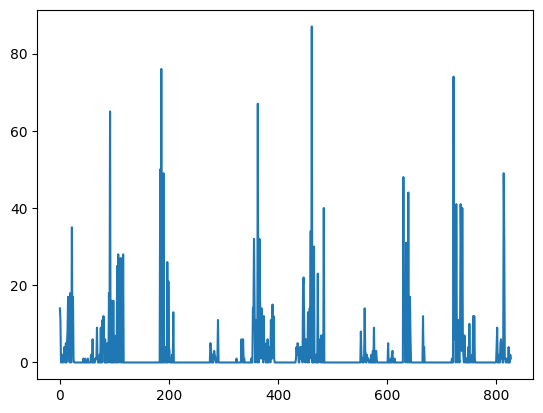

In [33]:
plt.plot(hist)

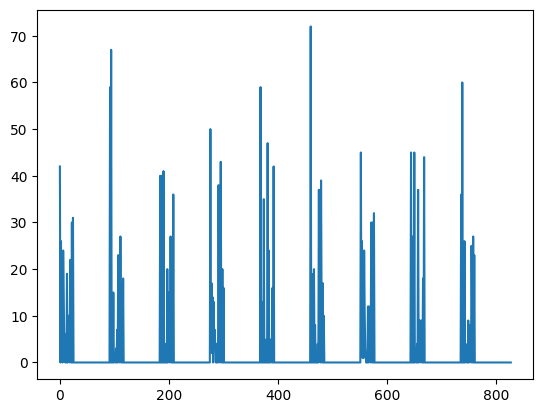

In [38]:
im , hist= _lbph_algorithm("data/validation/fear/10043.jpg", bins)
plt.figure()
plt.plot(hist)

In [2]:
from PIL import Image
import numpy
im = Image.open("data/train/angry/10.jpg").convert("L")
im = numpy.array(im)
l = []
l = numpy.split(im, list(range(16,im.shape[0],16)))
split = []
print(l[0].shape)
split = numpy.split(l[0], list(range(16,im.shape[0],16)), axis=1)
print(split[0].shape)
l = numpy.histogram(split[0],list(range(0,256)))
print(l[0])

(16, 48)
(16, 16)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  3  5  5 13  8  8  5
  7  3  3  2  3  5  2  5  5  0  0  0  0  1  1  0  2  1  1  1  1  1  1  1
  1  1  1  2  0  1  0  1  0  0  1  0  1  0  1  0  1  1  1  3  1  0  5  1
  3  1  1  0  3  2  1  4  0  1  1  1  0  2  4  2  0  3  1  2  0  1  0  0
  2  1  0  1  1  7  3  0  2  0  4  2  4  1  2  2  3  0  0  3  1  1  3  1
  5  3  1  1  2  4  0  4  0  2  3  1  3  1  0  2  3  1  3  2  4  2  3  0
  1  2  1  1  0  0  1  0  1  0  0  1  1  0  1  1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [6]:
import sklearn
import os

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!cp /content/drive/MyDrive/ColabData/FacialExpressionData/data.zip /content/data.zip

In [9]:
!rm -rf /content/savs

In [10]:
import zipfile
import os

current_dir = os.getcwd()

data_zip = current_dir + "/data.zip"
data_path = current_dir + "/data"

isColab = True

if isColab:
    os.mkdir(current_dir + "/savs")
    with zipfile.ZipFile(data_zip,"r") as zip:
        zip.extractall(data_path)

In [11]:
X = []
Y = []

TRAIN_PATH = "/content/data/train/"

cls  = os.listdir(TRAIN_PATH)

for i in range(len(cls)):
    imgs = os.listdir(TRAIN_PATH+cls[i])
    for img in imgs:
        path = TRAIN_PATH + cls[i] + "/" + img
        im = _fft_edge_detector(path, 25, False)
        #im = _get_image_as_array(path)
        X.append([im.flatten()])
        Y.append(i)


    

In [12]:
X = numpy.concatenate(X)
Y = numpy.asarray(Y)

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components='mle')
pca.fit(X,Y)
X_new = pca.transform(X)
#X_new = X

In [14]:
numpy.save('savs/X_fft_25', X_new)
numpy.save('savs/Y',Y)

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC())
clf.fit(X_new, Y)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [16]:

TEST_PATH = "/content/data/validation/"

X_test = []
Y_test = []

cls  = os.listdir(TEST_PATH)

for i in range(len(cls)):
    imgs = os.listdir(TEST_PATH+cls[i])
    for img in imgs:
        path = TEST_PATH + cls[i] + "/" + img
        im = _fft_edge_detector(path, 25, False)
        #im = _get_image_as_array(path)
        X_test.append([im.flatten()])
        Y_test.append(i)

X_test = numpy.concatenate(X_test)
Y_test = numpy.asarray(Y_test)

X_test = pca.transform(X_test)

Y_pred = clf.predict(X_test)

numpy.save('savs/X_test', X_test)
numpy.save('savs/Y_test',Y_test)
numpy.save('savs/Y_pred', Y_pred)

NameError: ignored

In [ ]:
from sklearn.metrics import accuracy_score

p = accuracy_score(Y_test, Y_pred)

print(p)

In [ ]:
import pickle
sav_non_pca = 'savs/svm_classifier_fft_25'
pickle.dump(clf,open(sav_non_pca,'wb'))

sav_pca = 'savs/pca_mle'
pickle.dump(pca, open(sav_pca, 'wb'))

In [ ]:
!zip -r /content/savs_svm_fft25.zip savs/

In [ ]:
!cp /content/savs_svm_fft25.zip /content/drive/MyDrive/ColabData/FacialExpressionData/savs_svm_fft25.zip

In [ ]:
print(X_test.shape)

In [ ]:
print(p)